## Оценка результатов A/B-теста 

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.


**Цель исследования** — оценить корректность проведения теста и проанализировать его результаты


**Задачи:**
- удостоверится, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.




**Техническое задание:**
- Название теста: recommender_system_test;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
 - конверсии в просмотр карточек товаров — событие product_page,
 - просмотры корзины — product_cart,
 - покупки — purchase.


**Описание данных:**
1) ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год.
**Структура файла:**
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

2) final_ab_new_users.csv — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

**Структура файла:**
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.


3) final_ab_events.csv — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

**Структура файла:**
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

4) final_ab_participants.csv — таблица участников тестов.
**Структура файла:**
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.



**Ход исследования:**

*Раздел1. Изучение общей информации:*

* [Загрузка библиотек](#1-bullet)
* [Изученеие файлов с данными, получение общей информации](#2-bullet)
* [Изучение данных датафрейма participants](#4-bullet)
* [Изучение данных датафрейма new_users](#5-bullet)
* [Изучение данных датафрейма events](#6-bullet)
* [Изучение данных датафрейма marketing_events](#7-bullet)
* [Вывод по разделу 1](#8-bullet)


*Раздел2. Оценка корректности проведения теста:*

* [Соответствие данных требованиям технического задания](#9-bullet)
* [Проверка на пересечение тестов](#10-bullet)
* [Проверка на пересечение групп в нашем тесте](#11-bullet)
* [Проверка региона новых пользователей и  сроков набора](#12-bullet)
* [Анализ пересечения между данными об участниках теста и данными о совершенных событиях¶](#13-bullet)
* [Анализ пересечения между проведением теста и маркетинговыми событиями](#14-bullet)
* [Вывод по разделу 2](#15-bullet)


*Раздел3. Исследовательский анализ данных:*
* [Распределение количества событий на пользователя в выборках](#16-bullet)
* [Распределение количества событий  в выборках по дням](#17-bullet)
* [Конверсия в воронке в выборках на разных этапах](#18-bullet)
* [Особенности данных перед проведением  A/B-теста](#19-bullet)

*[Раздел4.Оценка результатов A/B-тестирования. Проверка гипотез:*](#20-bullet)

* [Общий вывод и рекомендации для заказчика](#21-bullet)

# 1. Изучение общей информации

<a id='1-bullet'></a>
## Загрузка библиотек

In [1]:
# здесь сразу импортируем все библиотеки, которые потребуются в работе
import pandas as pd
import numpy as np
import math as mth

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from plotly import graph_objects as go
import plotly.express as px

from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

import statistics as stat
from datetime import datetime,timedelta


# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', 50)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# игнорируем предупреждения
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

<a id='2-bullet'></a>
## Изучение файлов с данными, получение общей информации

In [2]:
# чтение файлов с данными и сохранение в зависимости от того,
#где запущена тетрадь-локально или на сервере Яндекс.Практикума
import pandas as pd

try:
    participants, new_users, events, marketing_events = (
        pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv'), 
        pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv'))


except:
    participants, new_users, events, marketing_events = (
        pd.read_csv('/datasets/final_ab_participants.csv'),
        pd.read_csv('/datasets/final_ab_new_users.csv'),
        pd.read_csv('/datasets/final_ab_events.csv'), 
        pd.read_csv('/datasets/ab_project_marketing_events.csv'))

In [3]:
# Напишем функцию обзора данных
# функция для обзора данных
def df_review(df):
    display(df.head()) # вывод первых 5 строк датафрейма
    display('-'*80)
    print(df.info())# вывод информации о данных: тип данных, пропуски
    display('-'*80)
    display ('Число пропусков:',df.isna().sum())# вывод инф-ии по колонкам о пропусках
    display ('% пропусков:',round(df.isna().sum()/len(df)*100,2)) # процент пропущенных значений в столбцах
    display('-'*80)
    display(df.describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99]))# вывод инф-ии о мин-х, средних, макс-х значениях 
    display('-'*80)
    for columns in df.columns[1:]: # посмотрим какие значения и их количества хранятся в столбцах
        display ('Значения и их количество в столбцах:',df[columns]. value_counts())
        print()
    display('-'*80)
    for columns in df.columns[1:]: # посмотрим какие значения и их % хранятся в столбцах
        display ('Значения и их % от общего в  столбцах:',round(df[columns].value_counts(normalize=True),2))
        print()
    display('-'*80)
    print('Число явных дубликатов:', df.duplicated().sum())

<a id='3-bullet'></a>
### Изучим данные датафрейма **participants**

In [4]:
df_review(participants)

user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

'--------------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


'--------------------------------------------------------------------------------'

'Число пропусков:'

user_id    0
group      0
ab_test    0
dtype: int64

'% пропусков:'

user_id   0.00
group     0.00
ab_test   0.00
dtype: float64

'--------------------------------------------------------------------------------'

user_id  group            ab_test
count              18268  18268              18268
unique             16666      2                  2
top     BF6D4EF4B54B3E94      A  interface_eu_test
freq                   2   9655              11567

'--------------------------------------------------------------------------------'

'Значения и их количество в столбцах:'

A    9655
B    8613
Name: group, dtype: int64

'Значения и их количество в столбцах:'

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

'--------------------------------------------------------------------------------'

'Значения и их % от общего в  столбцах:'

A   0.53
B   0.47
Name: group, dtype: float64

'Значения и их % от общего в  столбцах:'

interface_eu_test         0.63
recommender_system_test   0.37
Name: ab_test, dtype: float64

'--------------------------------------------------------------------------------'

Число явных дубликатов: 0


В данных содержится информация об участниках тестов с разбивкой по группам и названия проводимых тестов. 

Всего 18268 событий, явных дубликатов и пропусков нет, 2 группы -А (9655 записей)и В (8613)записей,2 вида теста: interface_eu_test- 11567 записей, recommender_system_test-6701 записей.
Видно, что общее количество пользовталей 18268, уникальных номеров ID- 16666.

Согласно ТЗ нас интересует только recommender_system_test.

Рассмотрим подробнее, как у нас распределены user_id так как всего записей по пользователям 18268,а уникальных номеров ID- 16666

In [5]:
# смотрим сколько дубликатов в столбце user_id
print('Количество дубликатов в столбце user_id :',participants['user_id'].duplicated().sum())

Количество дубликатов в столбце user_id : 1602


Данные дубликаты могли возниктнуть из-за того, что одни и теже пользователи участвуют в 2-х тестах или попали в несколько групп тестов. Данный момент будет расммотрен подробнее далее, в разделе соответсвия данных ТЗ.

<a id='4-bullet'></a>
### Изучим данные датафрейма **new_users**

In [6]:
df_review(new_users)

user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone

'--------------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


'--------------------------------------------------------------------------------'

'Число пропусков:'

user_id       0
first_date    0
region        0
device        0
dtype: int64

'% пропусков:'

user_id      0.00
first_date   0.00
region       0.00
device       0.00
dtype: float64

'--------------------------------------------------------------------------------'

user_id  first_date region   device
count              61733       61733  61733    61733
unique             61733          17      4        4
top     574D9D8098B60C6F  2020-12-21     EU  Android
freq                   1        6290  46270    27520

'--------------------------------------------------------------------------------'

'Значения и их количество в столбцах:'

2020-12-21    6290
2020-12-14    5654
2020-12-07    5595
2020-12-13    4691
2020-12-20    4288
2020-12-12    3963
2020-12-19    3617
2020-12-18    3365
2020-12-08    3239
2020-12-22    3083
2020-12-10    3076
2020-12-17    3048
2020-12-15    3043
2020-12-11    2390
2020-12-23    2180
2020-12-16    2110
2020-12-09    2101
Name: first_date, dtype: int64

'Значения и их количество в столбцах:'

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

'Значения и их количество в столбцах:'

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

'--------------------------------------------------------------------------------'

'Значения и их % от общего в  столбцах:'

2020-12-21   0.10
2020-12-14   0.09
2020-12-07   0.09
2020-12-13   0.08
2020-12-20   0.07
2020-12-12   0.06
2020-12-19   0.06
2020-12-18   0.05
2020-12-08   0.05
2020-12-22   0.05
2020-12-10   0.05
2020-12-17   0.05
2020-12-15   0.05
2020-12-11   0.04
2020-12-23   0.04
2020-12-16   0.03
2020-12-09   0.03
Name: first_date, dtype: float64

'Значения и их % от общего в  столбцах:'

EU          0.75
N.America   0.15
CIS         0.05
APAC        0.05
Name: region, dtype: float64

'Значения и их % от общего в  столбцах:'

Android   0.45
PC        0.25
iPhone    0.20
Mac       0.10
Name: device, dtype: float64

'--------------------------------------------------------------------------------'

Число явных дубликатов: 0


Данные содержат информацию о всех пользователях, зарегистрировавшихся в интернет-магазине в период с 7 по 21 декабря 2020 года. Всего в данных 61733 строк. 
**Столбец с датой имеет некорректный тип-object, необходимо будет его преобразовать.**
В столбце region встречаются 4 различных региона: Европа-75%, Северная Америка-15%, СНГ и Азиатско-Тихоокеанский регион по 5% от общего количества.
Устройств, с которых регистрировались тоже 4: айфон-20%, андроид-45%, ПС-25% и макбук-10%.

<a id='5-bullet'></a>
### Изучим данные датафрейма **events**

In [7]:
df_review(events)

user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99

'--------------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None


'--------------------------------------------------------------------------------'

'Число пропусков:'

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

'% пропусков:'

user_id       0.00
event_dt      0.00
event_name    0.00
details      85.75
dtype: float64

'--------------------------------------------------------------------------------'

details
count 62,740.00
mean      23.88
std       72.18
min        4.99
5%         4.99
25%        4.99
50%        4.99
75%        9.99
95%       99.99
99%      499.99
max      499.99

'--------------------------------------------------------------------------------'

'Значения и их количество в столбцах:'

2020-12-23 02:37:24    10
2020-12-14 18:54:55    10
2020-12-24 00:54:52     9
2020-12-21 21:14:13     9
2020-12-20 02:51:18     9
                       ..
2020-12-17 05:45:20     1
2020-12-08 10:24:54     1
2020-12-13 19:47:37     1
2020-12-22 17:32:48     1
2020-12-15 03:04:20     1
Name: event_dt, Length: 267268, dtype: int64

'Значения и их количество в столбцах:'

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

'Значения и их количество в столбцах:'

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

'--------------------------------------------------------------------------------'

'Значения и их % от общего в  столбцах:'

2020-12-23 02:37:24   0.00
2020-12-14 18:54:55   0.00
2020-12-24 00:54:52   0.00
2020-12-21 21:14:13   0.00
2020-12-20 02:51:18   0.00
                      ... 
2020-12-17 05:45:20   0.00
2020-12-08 10:24:54   0.00
2020-12-13 19:47:37   0.00
2020-12-22 17:32:48   0.00
2020-12-15 03:04:20   0.00
Name: event_dt, Length: 267268, dtype: float64

'Значения и их % от общего в  столбцах:'

login          0.43
product_page   0.29
purchase       0.14
product_cart   0.14
Name: event_name, dtype: float64

'Значения и их % от общего в  столбцах:'

4.99     0.74
9.99     0.15
99.99    0.09
499.99   0.02
Name: details, dtype: float64

'--------------------------------------------------------------------------------'

Число явных дубликатов: 0


In [8]:
#Посмторим распределение  пропусков в events['details'] по событиям:
events.groupby('event_name')['details'].count()

event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

В данных содежится 440317 записей. Столбец с датой необходимо привести к типу datetime вместо object.
В столбце details имеются пропуски (86%), в данном случае это нормально, так как в этом столбце содержатся суммы покупок, которых всего 4 вида:4,99(74%) - 9,99(15%) - 99,99(9:) - 499,99(2%)). Таким образом пропуски можно классифицировать MNAR (Missing Not At Random / Отсутствует не случайно) — пропуски зависят от данных, их нельзя отбрасывать, т.к. это приведёт к заметным искажениям.

Датасет содержит все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года; В столбце event_name встречается 4 различных события: 
- login - авторизация на сайте 43%
- product_page - просмотры корзины 29%
- purchase - покупки 14%
- product_cart - просмотр карточек товаров 14%


Явные дубликаты отсутсвуют.

<a id='6-bullet'></a>
### Изучим данные датафрейма **marketing_events**

In [9]:
df_review(marketing_events)

name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11

'--------------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


'--------------------------------------------------------------------------------'

'Число пропусков:'

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

'% пропусков:'

name        0.00
regions     0.00
start_dt    0.00
finish_dt   0.00
dtype: float64

'--------------------------------------------------------------------------------'

name regions    start_dt   finish_dt
count                              14      14          14          14
unique                             14       6          14          14
top     Dragon Boat Festival Giveaway    APAC  2020-05-01  2020-12-01
freq                                1       4           1           1

'--------------------------------------------------------------------------------'

'Значения и их количество в столбцах:'

APAC                        4
EU, CIS, APAC, N.America    3
EU, CIS, APAC               2
EU, N.America               2
CIS                         2
N.America                   1
Name: regions, dtype: int64

'Значения и их количество в столбцах:'

2020-05-01    1
2020-04-12    1
2020-01-25    1
2020-02-14    1
2020-11-26    1
2020-05-09    1
2020-10-01    1
2020-06-25    1
2020-07-04    1
2020-03-08    1
2020-12-30    1
2020-11-11    1
2020-12-25    1
2020-03-17    1
Name: start_dt, dtype: int64

'Значения и их количество в столбцах:'

2020-12-01    1
2020-07-11    1
2020-07-01    1
2020-05-03    1
2020-04-19    1
2020-10-07    1
2020-02-07    1
2020-03-10    1
2020-02-16    1
2020-05-11    1
2020-03-19    1
2020-11-12    1
2021-01-03    1
2021-01-07    1
Name: finish_dt, dtype: int64

'--------------------------------------------------------------------------------'

'Значения и их % от общего в  столбцах:'

APAC                       0.29
EU, CIS, APAC, N.America   0.21
EU, CIS, APAC              0.14
EU, N.America              0.14
CIS                        0.14
N.America                  0.07
Name: regions, dtype: float64

'Значения и их % от общего в  столбцах:'

2020-05-01   0.07
2020-04-12   0.07
2020-01-25   0.07
2020-02-14   0.07
2020-11-26   0.07
2020-05-09   0.07
2020-10-01   0.07
2020-06-25   0.07
2020-07-04   0.07
2020-03-08   0.07
2020-12-30   0.07
2020-11-11   0.07
2020-12-25   0.07
2020-03-17   0.07
Name: start_dt, dtype: float64

'Значения и их % от общего в  столбцах:'

2020-12-01   0.07
2020-07-11   0.07
2020-07-01   0.07
2020-05-03   0.07
2020-04-19   0.07
2020-10-07   0.07
2020-02-07   0.07
2020-03-10   0.07
2020-02-16   0.07
2020-05-11   0.07
2020-03-19   0.07
2020-11-12   0.07
2021-01-03   0.07
2021-01-07   0.07
Name: finish_dt, dtype: float64

'--------------------------------------------------------------------------------'

Число явных дубликатов: 0


В датасете представлен календарь маркетинговых событий на 2020 год. Всего 14 событий. Столбцы с датой имеют некорректный тип object.
Пропусков в данных нет, явных дубликатов нет.


В период проведения теста проходила промоакция "Christmas&New Year Promo" (с 25 декабря по 3 января). Это может повлиять на чистоту результатов тестирования.

<a id='7-bullet'></a>
## Преобразование типов данных

In [10]:
#приводим столбцы с датами к нужному типу
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

<a id='8-bullet'></a>
## Вывод по разделу 1

В данном разделе были загружены библиотеки для работы с данными, подробно рассмотрены все 4 файла с данными:

- явных дубликатов нет;
- пропуски есть только в столбце events['details'], но носят естественный характер, так как данные в этом столбце указаны в случае совершения покупки, пропуски нельзя заполнять или удалять.
- в столбцах тап дат был переведен из object в  datetime
- в данных об участниках встречается 1602 дубликата user_id, появление дубликатов могут быть из-за попадание в оба теста или в несколько групп одного теста 


# Оценка корректности проведения теста

<a id='9-bullet'></a>
## Соответствие данных требованиям технического задания

Проверим соответствие данных требованиям технического задания по всем пунктам:
**Техническое задание: **
- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
 - конверсии в просмотр карточек товаров — событие product_page,
 - просмотры корзины — product_cart,
 - покупки — purchase.

### Проверка аудитории теста

<a id='10-bullet'></a>
####   Проверка на пересечение тестов
Проверим, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

Ранее уже выяснили, что у нас есть 1602 задублированных записи об участниках теста, посмотрим, как они распределяются по тестам и группам.

In [11]:
#смотрим распределение пользователей по тестам и по группам
participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

Помимо нашего тестирования (внедрение улучшеной рекомендательной системы) проводилось крупное исследование по результатам изменения интерфейса.
В интересующем нас тесте recommender_system_test имееется две группы. В группе А -3824 пользователя, а в группе В-2877.

In [12]:
# теперь посмотрим сколько человек участвовало в 2-х тестах
dbl=participants.groupby('user_id')['ab_test'].nunique().reset_index().query('ab_test > 1')
'Количество пользователей, участвующих в обоих тестах:',dbl.shape[0]

('Количество пользователей, участвующих в обоих тестах:', 1602)

У нас есть пользователи, которые попали в параллельный тест в обе группы, а это значит, что те, кто был в группе  B- видели изменения. Нужно посмотреть, как эти пользователи распределены по нашему тесту: если они равномерно распределены по нашим группа А и В- то их можно оставить, если же их распределение по нашим группам неравномерное- то это может исказить результаты теста.

In [13]:
 # выделяем пользователей, попавших в оба теста
part_dbl=participants[participants['user_id'].isin(dbl['user_id'].values)]
part_dbl.head(6)

user_id group                  ab_test
2   DABC14FDDFADD29E     A  recommender_system_test
3   04988C5DF189632E     A  recommender_system_test
10  B3A2485649E4A012     A  recommender_system_test
25  EAFB9027A27D510C     B  recommender_system_test
29  5D5E6EE92AF6E9E0     B  recommender_system_test
31  D6E62099519F986C     A  recommender_system_test

In [14]:
#выделяем тех, кто попал в группу B теста interface_eu_test
part_dbl_b=part_dbl.query('ab_test=="interface_eu_test" and group=="B"')
display(part_dbl_b.head())
print('Количество человек в группе B теста interface_eu_test',part_dbl_b.shape[0])

user_id group            ab_test
6705  2BA8FA8754D1FE50     B  interface_eu_test
6706  FB6F6BC119E1DBD5     B  interface_eu_test
6725  7060BB1CBE3BAACC     B  interface_eu_test
6727  97248D21983C5DBC     B  interface_eu_test
6738  8E69896F59A3B8F8     B  interface_eu_test

Количество человек в группе B теста interface_eu_test 783


In [15]:
# отсекаем пользователей другого теста, так как не знаем, какой тест повлиял на их поведение
participants = participants.query('ab_test == "recommender_system_test"')
print('Оставшееся количество участников теста',participants.shape[0])

Оставшееся количество участников теста 6701


6701 пока  удовлетворяет условиям ТЗ

<a id='11-bullet'></a>
#### Проверка на пересечение групп в нашем тесте

In [16]:
part=participants.groupby(['ab_test', 'group'])['user_id'].count().reset_index()
part['share']= (part['user_id']/part['user_id'].sum()* 100).round(1)
display(part)
print(participants.shape[0])

ab_test group  user_id  share
0  recommender_system_test     A     3824  57.10
1  recommender_system_test     B     2877  42.90

6701


57% пользователей попали в группу А и 43% пользователей попали в группу В.

In [17]:
#Проверим, что участники не попадают одновременно в группу А и В.
print('Количество участников в обеих группах теста',participants.\
      groupby('user_id')['group'].nunique().reset_index().query('group > 1').shape[0])

Количество участников в обеих группах теста 0


<a id='12-bullet'></a>
####  Проверка региона новых пользователей и  сроков набора 

Проверим сколько  участников теста удовлетворяют условию ТЗ о  новых зарегистрированных пользователей. 
1) Участники теста должны быть набраны  в период с 2020-12-07 и не позднее 2020-12-21.
2) В тест должно быть отобрано 15% новых пользователей из региона EU

In [18]:
#сначала проверим даты записей в таблице с данными о новых пользователях и 
# соотнесем их с ТЗ
print (new_users['first_date'].min())
print (new_users['first_date'].max())

2020-12-07 00:00:00
2020-12-23 00:00:00


Начало даты регистрации в таблице с новыми пользователями соответствуют ТЗ, а вот окончание -  больше на два дня.

In [21]:
#проверим все ли участники теста есть в таблице новых пользователей
new_users_id=new_users['user_id'].sort_values()
users_test = participants['user_id'].sort_values()
intersection = set(new_users_id).intersection(users_test)
len(intersection)

6701

In [22]:
# Объединим таблицы с участниками и новыми пользователями
new_part=participants.merge(new_users, on='user_id', how='left')
new_part.head()

user_id group                  ab_test first_date region  device
0  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU      PC
1  A7A3664BD6242119     A  recommender_system_test 2020-12-20     EU  iPhone
2  DABC14FDDFADD29E     A  recommender_system_test 2020-12-08     EU     Mac
3  04988C5DF189632E     A  recommender_system_test 2020-12-14     EU  iPhone
4  482F14783456D21B     B  recommender_system_test 2020-12-14     EU      PC

In [23]:
# Проверим даты начала набора и окончания набора пользователей по нашему тесту

In [24]:
print (new_part['first_date'].min())
print (new_part['first_date'].max())

2020-12-07 00:00:00
2020-12-21 00:00:00


Даты начала набора и окончания набора пользователей по нашему тесту соответсвуют ТЗ

In [25]:
# проверим ТЗ на долю частников из Европы, должно быть 15%
new_part=new_part.query('region=="EU"')
#выводим новых пользователей, зарегистрированных в сроки набора нашего теста'
new_users_eu_test=new_users.query('first_date <= "2020-12-21 23:59:59" and region=="EU"')
print('% новых участников теста из EU по отношению ко всем новым пользователям из EU,\
      зарегистрированным в сроки набора нашего теста',\
      round((new_part['user_id'].\
      nunique()/new_users_eu_test['user_id'].nunique()*100),2))

% новых участников теста из EU по отношению ко всем новым пользователям из EU,      зарегистрированным в сроки набора нашего теста 15.0


Условие ТЗ соблюдено

<a id='13-bullet'></a>
#### Анализ пересечения между данными об участниках теста и данными о совершенных событиях

In [26]:
users_event = events['user_id'].sort_values()
users_test = participants['user_id'].sort_values()
intersection_b = set(users_event).intersection(users_test)
len(intersection_b)

3675

Всего 3675 участников теста совершали действия. Это явно меньше условия ТЗ(6000).

Но использовать данные по всем пользователям мы не можем (это значительно исказит результаты), поэтому пожертвуем мощностью теста и оставим только пересекающихся пользователей. У нас нет информации, по какой причине отсутствует информация о событиях совершенных новыми участниками теста, возможно это техническая ошибка.

In [27]:
# Сохраним всех пользователей теста и события
new_part_all=new_part.merge(events, on='user_id', how='left')
new_part_all.head()

user_id group                  ab_test first_date region device  \
0  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
1  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
2  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
3  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   
4  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU     PC   

             event_dt    event_name  details  
0 2020-12-07 14:43:27      purchase    99.99  
1 2020-12-25 00:04:56      purchase     4.99  
2 2020-12-07 14:43:29  product_cart      NaN  
3 2020-12-25 00:04:57  product_cart      NaN  
4 2020-12-07 14:43:27  product_page      NaN

In [28]:
# Участники теста, у которых есть события
new_part_events=events.merge(new_part, on='user_id')
# убираем  колонку с названием теста
new_part_events.drop(columns=['ab_test'])
#проверяем, правильно ли объединила
print(new_part_events['user_id'].nunique())
new_part_events.head()

3481


user_id            event_dt    event_name  details group  \
0  831887FE7F2D6CBA 2020-12-07 06:50:29      purchase     4.99     A   
1  831887FE7F2D6CBA 2020-12-09 02:19:17      purchase    99.99     A   
2  831887FE7F2D6CBA 2020-12-07 06:50:30  product_cart      NaN     A   
3  831887FE7F2D6CBA 2020-12-08 10:52:27  product_cart      NaN     A   
4  831887FE7F2D6CBA 2020-12-09 02:19:17  product_cart      NaN     A   

                   ab_test first_date region   device  
0  recommender_system_test 2020-12-07     EU  Android  
1  recommender_system_test 2020-12-07     EU  Android  
2  recommender_system_test 2020-12-07     EU  Android  
3  recommender_system_test 2020-12-07     EU  Android  
4  recommender_system_test 2020-12-07     EU  Android

In [29]:
# проверим, есть ли среди наших участников теста с событиями те, кто попал в параллельный тест в группу В
new_part_events[new_part_events['user_id'].isin(dbl['user_id'])].nunique()

user_id        887
event_dt      3951
event_name       4
details          4
group            2
ab_test          1
first_date      15
region           1
device           4
dtype: int64

Всего из участников теста с событиями 887 человек, кто попал в параллельный тест, проверим, сколько из них из группы В параллельного теста, так как для сохранения мощности теста участников из группы А мы можем оставить, а вот из группы В никто не должен попасть к нам в тест.

In [30]:
# проверим, есть ли среди наших участников теста с событиями те, кто попал в параллельный тест в группу В
new_part_events[new_part_events['user_id'].isin(part_dbl_b['user_id'])].nunique()

user_id        431
event_dt      1918
event_name       4
details          4
group            2
ab_test          1
first_date      15
region           1
device           4
dtype: int64

431 человек из группы В параллельного теста оказался в нашей выборке усатников теста с событиями, таких людей необходимо удалить, чтобы результаты теста были достоверными, так как эти пользователи видели измененеия.
А для пользователей из группа А параллельного теста надо выяснить, равномерно ли они распределены по группам нашего теста, чтобы принять решение о их оставлении.

In [31]:
#пересохраняем new_part_events уже без участников группы В параллельного теста
part_dbl_b_id=part_dbl_b["user_id"]

new_part_events=new_part_events.query('user_id not in @part_dbl_b_id')
new_part_events['user_id'].nunique()

3050

In [32]:
#смотрим распределение по группам в нашей выборке new_part_events
test_ev=new_part_events.groupby(['group'])['user_id'].nunique().reset_index()
test_ev['share']= (test_ev['user_id']/test_ev['user_id'].sum()* 100).round(1)
display(test_ev)


group  user_id  share
0     A     2279  74.70
1     B      771  25.30

In [33]:
new_part_all=new_part_all.query('user_id not in @part_dbl_b_id')
new_part_all['user_id'].nunique()

5568

In [34]:
#выделяем тех, кто попал в группу  А теста interface_eu_test
part_dbl_a=part_dbl.query('ab_test=="interface_eu_test" and group=="A"')

print('Количество участников параллельного теста группы А среди участиников нашего теста')

#оставляем среди них пользователей только нашего теста:
part_a = new_part_events[new_part_events['user_id'].isin(part_dbl_a['user_id'].values)]
print(part_a['user_id'].nunique())

part_a=part_a.groupby(['ab_test', 'group'])['user_id'].nunique().reset_index()
part_a.insert(1, 'total', part_a['user_id'].nunique())
part_a['share']= (part_a['user_id']/part_a['user_id'].sum()* 100).round(1)
part_a

Количество участников параллельного теста группы А среди участиников нашего теста
456


ab_test  total group  user_id  share
0  recommender_system_test      2     A      340  74.60
1  recommender_system_test      2     B      116  25.40

Видно, что участиники группы А конкурирующего теста распределились по группам нашего теста в соотношении 74,60% к 25,40%
Проведем z-test и проверим гипотезу о равенстве пропорций пользователей из группы А теста-конкурента в группе А и группе В нашего теста:

Н0-доли уникальных посетителей одинаковы в обеих группах
Н1-доли уникальных посетителей одинаковы в обеих группах отличаются

In [35]:
# формирование функции
def ztest (trials_1, trials_2, successes_1, successes_2, alpha):
    
    # пропорция событий в первой группе
    p1 = successes_1/trials_1
    
    # пропорция событий во второй группе
    p2 = successes_2/trials_2
    
    print(successes_1, successes_2, trials_1, trials_2)

    # пропорция событий в комбинированном датасете
    p_combined = (successes_1 + successes_2) / (trials_1 +  trials_2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /mth.sqrt(p_combined * (1 - p_combined) * 
                                    (1 / trials_1 + 1 / trials_2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    pr_1 = print(f'p-значение: {p_value} \
                 alpha- значение: {alpha}')
    
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [36]:
ztest (test_ev.iloc[0,1],
       test_ev.iloc[1,1],
       part_a.iloc[0,3],
       part_a.iloc[1,3], 0.05)

340 116 2279 771
p-значение: 0.9321057672353459                  alpha- значение: 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


`Это значит, что пользователи равномерно распределились между группами А и В исследуемого теста и вносят примерно одинаковые изменения в результаты теста. Для сохранения мощности теста этих пользователей можно оставить.

In [37]:
# проверим долю участников  теста из Европы, у которых есть события ,
#по отношению ко всем новым пользователям из EU'
print('% новых участников теста из EU по отношению ко всем новым пользователям из EU',\
      round((new_part_events.query('region=="EU"')['user_id'].\
      nunique()/new_users.query('region=="EU"')['user_id'].nunique()*100),2))

% новых участников теста из EU по отношению ко всем новым пользователям из EU 6.59


In [38]:
# проверим долю участников теста из Европы, у которых есть события,
#по отношению ко всем новым пользователям 
print('% новых участников теста из EU по отношению ко всем новым пользователям',\
      round((new_part_events.query('region=="EU"')['user_id'].\
      nunique()/new_users['user_id'].nunique()*100),2))

% новых участников теста из EU по отношению ко всем новым пользователям 4.94


In [39]:
# проверим долю участников  теста по отношению  ко всем новым пользователям из EU'
print('% новых участников теста из EU по отношению ко всем новым пользователям из EU',\
      round((new_part_all['user_id'].\
      nunique()/new_users.query('region=="EU"')['user_id'].nunique()*100),2))

% новых участников теста из EU по отношению ко всем новым пользователям из EU 12.03


In [40]:
# подсчитаем разницу в днях между регистрацией и событием
new_part_events['diff'] = new_part_events['event_dt'] -new_part_events['first_date']
new_part_events['diff']=new_part_events['diff'].dt.days
# уберем все, что находится за границей 14 дней с момента регистрации
new_part_events = new_part_events.query('diff <= 14')

In [41]:
full=new_part_all.groupby(['group'])['user_id'].nunique().reset_index()
full['share']=(full['user_id']/full['user_id'].sum()* 100).round(2)
display(full)
print('Количество участников теста - %s'%new_part_all['user_id'].nunique())

group  user_id  share
0     A     3195  57.38
1     B     2373  42.62

Количество участников теста - 5568


In [42]:
test_ev=new_part_events.groupby(['group'])['user_id'].nunique().reset_index()
test_ev['share']= (test_ev['user_id']/test_ev['user_id'].sum()* 100).round(1)
display(test_ev)
print('Количество участников теста - %s'%new_part_events['user_id'].nunique())

group  user_id  share
0     A     2279  74.70
1     B      771  25.30

Количество участников теста - 3050


In [43]:
print('Количество участников теста не совершавших действия',\
      new_part_all['user_id'].nunique()-new_part_events['user_id'].nunique())

Количество участников теста не совершавших действия 2518


<a id='14-bullet'></a>
#### Анализ пересечения между проведением теста и маркетинговыми событиями

In [44]:
# сравниваем периоды маркетинговых активностей с общим периодом проведения теста.
marketing_events.query("start_dt>datetime(2020,12,7) & start_dt<datetime(2021,1,4)")

name        regions   start_dt  finish_dt
0    Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03
10  CIS New Year Gift Lottery            CIS 2020-12-30 2021-01-07

Во время набора новых пользователей не было пересечения с маркетинговыми акциями. Однако до завершения теста  есть пересеение  с одной промоакцией Christmas&New Year Promo, проводимой в том числе в Европе с 25 декабря 2020 по 3 января 2021.

Такого рода акция могла существенно повлиять на решении совершить покупку клиентом и на остальные ключевые метрики конверсии.

Чтобы проверить  повлияла ли акция на результаты нашего теста посмотрим динамику количества событий  за период проведения теста.

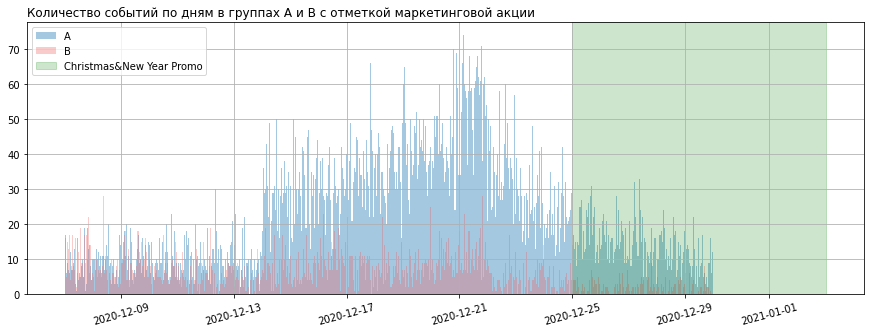

In [45]:
plt.title('Количество событий по дням в группах А и В c отметкой маркетинговой акции', loc='Left')
new_part_events[new_part_events['group'] == 'A']['event_dt'].hist(bins = 29*24,  figsize=(15, 5), label = 'A', alpha=.4)
new_part_events[new_part_events['group'] == 'B']['event_dt'].hist(bins = 29*24,  figsize=(15, 5), color = '#f05454', label = 'B', alpha=.3)
plt.axvspan('2020-12-25', '2021-01-03', color='green', alpha=.2, label = 'Christmas&New Year Promo')
plt.xticks(rotation=15)
plt.legend()
plt.show()

Как видно из графика никакого всплеска или бума активности не наблюдается в период проведения акции, поэтому не будем избавляться за данные за этот период. Нf гистограмме, также видно, что дейсвия пользователей закончились ранее 04.01.2021, посмотрим даты событий.

In [46]:
print(new_part_events['event_dt'].min())
print(new_part_events['event_dt'].max())

2020-12-07 00:05:57
2020-12-29 23:38:29


Последнее событие у нас 29 декабря 2020 года, хотя до остановки теста еще 4 дня. Интересено, куда делись остальные события?

<a id='15-bullet'></a>
## Вывод по разделу 2

Тест был проведен с нарушениями и есть несоответсвия с ТЗ:

- Параллельно с нашим тестом еще один тест interface_eu_test. Количество пользователей, попавших одновременно в оба теста 1602.

- Количество  всех участников в  тесте  6701, в группе  А  и В сильно различается(3385 и 2533, соответственно 57,20% и 42,80%).
- Количество участников теста из Европы, которые не совершили ни одного действия - 2518, совершившие действия участники группы  А  и В (2279 и 771, соответственно 74,70% и 25,30%). Группы , совершивших действия тест распределены неравномерно. Однако, при достаточной выборке данный факт может не быть критическим, этот момент проверим далее с помощью онлайн-калькулятора.

- требования ТЗ о 15% соблюден

- В период с 25.12.2020 по 03.01.2021 в EU проводилась акция "Christmas&New Year Promo".
Данная акция не повлияла на результаты теста, однако на графике зафиксирована сезонная активность, приходящаяся на 21 декабря- какнун рождества, так как в Европе рождество 25 января, то все в этот период закупают подарки.

- В выгрузке нет данных о событиях с 31.12.2020 по 04.01.2021 (время остановки теста). Не хватает информации за 5 дней.

Всё вышеперечисленное может искажать результаты тестирования.


##  Исследовательский анализ данных

<a id='16-bullet'></a>
### Распределение количества событий на пользователя в выборках

In [47]:
u_events=new_part_events.pivot_table(index=['group', 'event_name'],values='user_id', aggfunc={'count', 'nunique'})
u_events=u_events.rename(columns={'count':'events', 'nunique':'users'})
u_events['avg']=u_events['events']/u_events['users']
u_events

events  users  avg
group event_name                      
A     login           7018   2279 3.08
      product_cart    2114    686 3.08
      product_page    4514   1476 3.06
      purchase        2205    734 3.00
B     login           2036    770 2.64
      product_cart     542    214 2.53
      product_page    1074    429 2.50
      purchase         531    219 2.42

Видно, что для группы А количество событий на пользователя больше, чем в группе B.
Выделим выборки по этим группам, чтобы построить графики

In [48]:
events_a = new_part_events.query('group == "A"')
events_b = new_part_events.query('group == "B"')
ev_a = events_a.groupby('user_id').agg({'user_id':'count'}).rename(columns={'user_id':'Group A'})
ev_b = events_b.groupby('user_id').agg({'user_id':'count'}).rename(columns={'user_id':'Group B'})

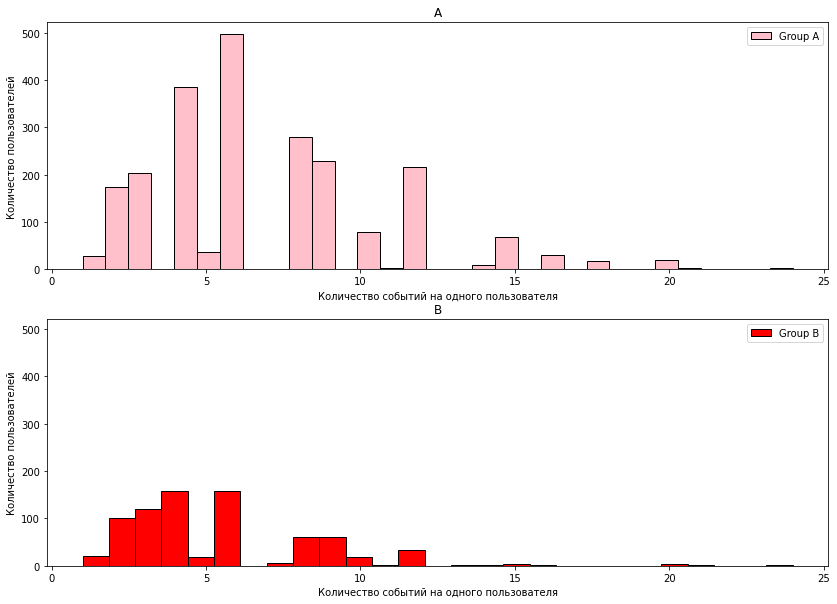

In [49]:
plt.figure(figsize=(14, 10))
ax1 = plt.subplot(2, 1, 1)
sns.histplot(ev_a, facecolor='pink')
plt.title('A')
plt.xlabel('Количество событий на одного пользователя')
plt.ylabel('Количество пользователей')

ax2 = plt.subplot(2, 1, 2, sharey = ax1)
sns.histplot(ev_b, facecolor='red')
plt.title('B')
plt.xlabel('Количество событий на одного пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Количество событий на одного пользователя распределены наравномерно в обеих группах. В группе "А"  неравномерность больше- больше разница между пиками и провалами

In [50]:
# посмотрим, сколько событий в среднем приходится на пользователя:
events_by_user_a = events_a.groupby('user_id').agg(event_count = ('event_name', 'count')).reset_index()
events_by_user_b = events_b.groupby('user_id').agg(event_count = ('event_name', 'count')).reset_index()

print('Количество событий в среднем на пользователя группа А')
display(events_by_user_a['event_count'].describe())  

print('Количество событий в среднем на пользователя группа  B')
display(events_by_user_b['event_count'].describe()) 

Количество событий в среднем на пользователя группа А


count   2,279.00
mean        6.96
std         3.85
min         1.00
25%         4.00
50%         6.00
75%         9.00
max        24.00
Name: event_count, dtype: float64

Количество событий в среднем на пользователя группа  B


count   771.00
mean      5.43
std       3.25
min       1.00
25%       3.00
50%       4.00
75%       7.00
max      24.00
Name: event_count, dtype: float64

По медиане без учета выбросов на пользователя приходится порядка 6 событий в группе А и 4 событий в группе В. При этом, минимальное количество  событий в группе А и В- всего одно, а максимальное - 24 шт.

Проведем статистическую проверку, и сформулиреум гипотезы
H0-среднее количество событий на пользователя в группе А и группе В одинаково
Н1-среднее количество событий на пользователя в группе А и группе В различается

In [51]:
#Выполним тест Манна-Уитни
events_by_user_a=events_by_user_a.drop(columns=['user_id']).dropna()
events_by_user_b=events_by_user_b.drop(columns=['user_id']).dropna()

#За критический уровень статистической значимости alpha примем значение 0,05
alpha = 0.05  

results = st.mannwhitneyu(events_by_user_a,events_by_user_b)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: ЕСТЬ статистически значимое различие в доходах ')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу:  НЕТ статистически значимого различия в доходах '
    ) 

p-значение:  [1.0571263e-24]
Отвергаем нулевую гипотезу: ЕСТЬ статистически значимое различие в доходах 


<a id='17-bullet'></a>
###  Распределение количества событий  в выборках по дням

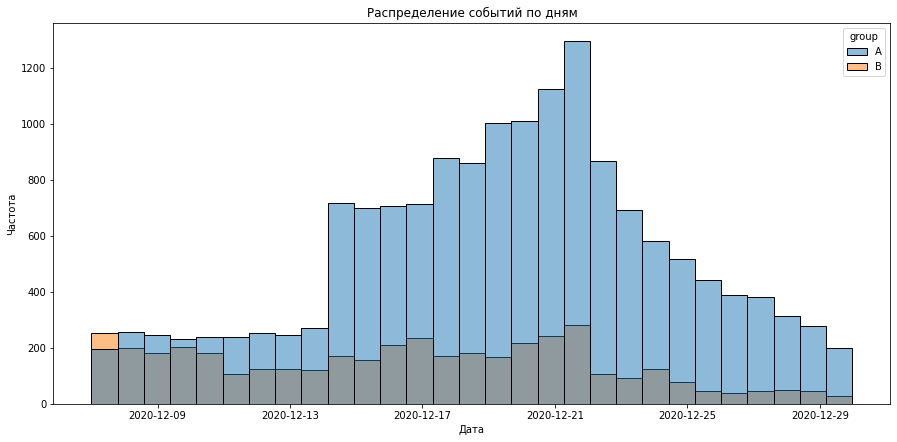

In [52]:
#строим график динамики количества событий  в разрезе групп по дням
plt.figure(figsize=(15, 7))
sns.histplot(data=new_part_events, x='event_dt', hue='group',bins=29)
plt.title('Распределение событий по дням')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.show()

С 15 декабря количество событий для группы А резко увеличилось вплоть до 22 декабря, затем начался плавный спад. в Европе Рождество 25 декабря и все закупают подарки к этому времени.
Однако события в группе В распределены более равномерно с небольшими пиками на 17 декабря и 22.12. Интересно, что эти пики не поднимались выше значений в начале периода- с 7 по 10 декабря

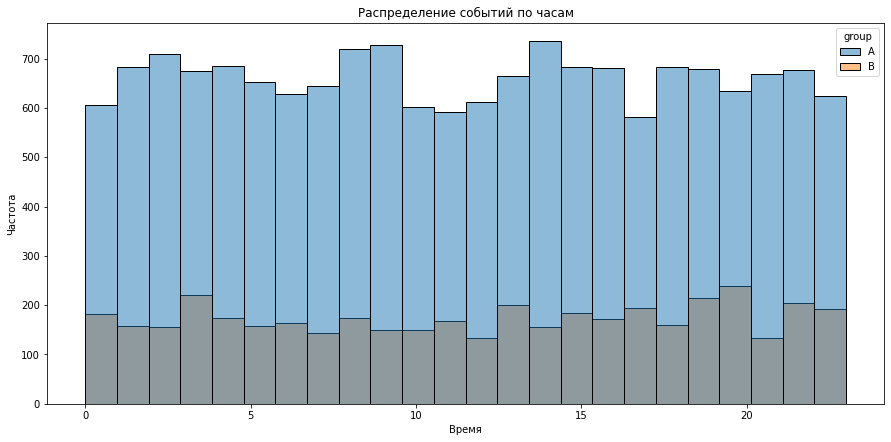

In [53]:
plt.figure(figsize=(15, 7))
sns.histplot(data=new_part_events, x=new_part_events['event_dt'].dt.hour, hue='group',bins=24)
plt.title('Распределение событий по часам')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.show()

По времени суток особых различий нет.

Расмотрим динамику набора новых пользователей в разрезе по группам, так как скорее всего, это объяснит рост количества событий, начиная с 15 декабря

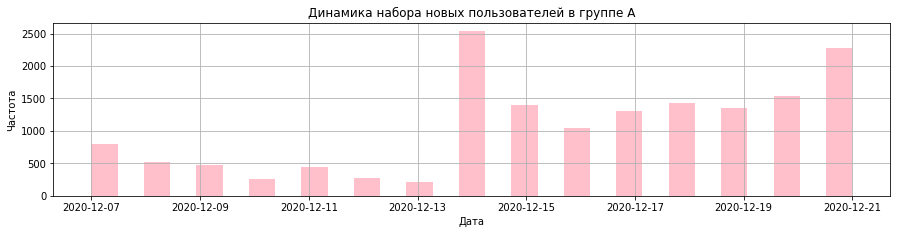

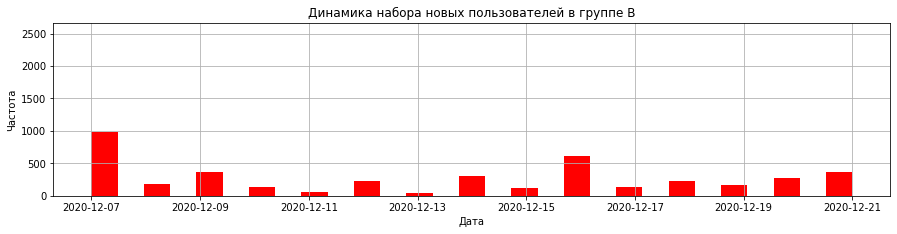

In [54]:
plt.figure(figsize=(15, 7))
ax1 = plt.subplot(2, 1, 1)
new_part_events.query('group=="A"')["first_date"].hist(bins=29, facecolor='pink')
plt.title('Динамика набора новых пользователей в группе А')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(15, 7))
ax2 = plt.subplot(2, 1, 2, sharey = ax1)
new_part_events.query('group=="B"')["first_date"].hist(bins=29, facecolor='red')
plt.title('Динамика набора новых пользователей в группе В')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.show()


Как видно из динамики унас рост  количества событий  с 14 декабря объясняется ростов количества новых участников теста в группе А.
А в группе В всплески регистрации возникли 16 декабря, но это не дало не колоссального подъема активности.

In [55]:
# количество активных пользователей в разбивке по группам по дням
unid_perday=new_part_events
unid_perday['date_ev']=unid_perday['event_dt'].dt.date
unid_perday=unid_perday.groupby(['date_ev','group']).agg({'user_id': 'nunique'}).reset_index()
unid_perday.head()

date_ev group  user_id
0  2020-12-07     A      122
1  2020-12-07     B      142
2  2020-12-08     A      133
3  2020-12-08     B       99
4  2020-12-09     A      150

In [56]:
fig = px.bar(unid_perday, 
             y='user_id',
             x='date_ev',
             text='user_id',
             color='group'
            )
# оформляем график
fig.update_layout(xaxis={'categoryorder':'total descending'},
    title='Количество активных пользователей в разбивке по группам по дням',
                   xaxis_title='Даты',
                   yaxis_title='Количество пользователей',
                   width=900, # указываем размеры графика
                   height=800)
fig.show() # выводим график


In [57]:
#среднее количество пользователей в день для обеих групп
visitors=unid_perday.groupby(['date_ev'])['user_id'].sum()
print('Cреднее количество пользователей в день для обеих групп',visitors.mean())
print('Cреднее количество пользователей в день для группы А-',round(unid_perday.query('group=="A"')['user_id'].mean()))
print('Cреднее количество пользователей в день для группы B-',round(unid_perday.query('group=="B"')['user_id'].mean()))

Cреднее количество пользователей в день для обеих групп 394.0
Cреднее количество пользователей в день для группы А- 305
Cреднее количество пользователей в день для группы B- 89


<a id='18-bullet'></a>
###  Конверсия в воронке в выборках на разных этапах

Посмотрим, какие события есть в логах, как часто они встречаются.

In [58]:
#посмотрим какие значения и их количества хранятся в столбцах
display ('Значения и их количество в столбцах:',new_part_events['event_name'].\
value_counts().reset_index().\
         rename(columns={'index' : 'event_name','event_name' : 'count'}).\
         sort_values(by='count', ascending=False))

#    display('-'*80)
#for columns in new_part_events.columns[1:]: # посмотрим какие значения и их % хранятся в столбцах
#    display ('Значения и их % от общего в  столбцах:',round(df[columns].value_counts(normalize=True),2))


'Значения и их количество в столбцах:'

event_name  count
0         login   9054
1  product_page   5588
2      purchase   2736
3  product_cart   2656

login (авторизовались) 9054 раз;
product_page (карточка товара) увидели 5588 раза;
product_card (корзина) увидели 2736 раза;
purchase (покупка) совершили 2656 раза.

Ожидаемая последовательность событий **Авторизация -> Просмотр товара -> Просмотр корзины -> Покупка.**

Отсортируем события по числу пользователей. 

In [59]:
funnel = (new_part_events.
              groupby('event_name').
              agg({'user_id': 'nunique'}).
              reset_index().
              rename(columns={'user_id' : 'total_users'}).
              sort_values(by='total_users', ascending=False))
funnel['percent'] = funnel['total_users'] / new_part_events['user_id'].nunique() * 100  
funnel['n'] = [1, 2, 4, 3]
funnel = funnel.sort_values(by='n')
funnel

event_name  total_users  percent  n
0         login         3049    99.97  1
2  product_page         1905    62.46  2
1  product_cart          900    29.51  3
3      purchase          953    31.25  4

In [60]:
fig = go.Figure(go.Funnel(y = funnel['event_name'],
                          x = funnel['total_users'],
                          opacity = 0.6,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title_text='Воронка событий по всем участникам теста')
fig.show()

Наибольшее количество пользователей теряется после первого шага (более 37%).
Только 31,25% от первоначального количества пользователей успешно оплачивают товары из корзины.
При этом, количество пользователей, оплативших покупки, больше, чем тех, кто перешел в Корзину. Очевидно, при переходе на карточку товара можно сразу оплатить товар, косвенно можно сказать, что в таком случае делается покупка одного товра, а через корзину чаще покупают сразу несколько товаров.

In [61]:
funnel_gr = (new_part_events.groupby(['event_name','group']).
              agg({'user_id': 'nunique'}).
              reset_index().
              rename(columns={'user_id' : 'total_users'}).
              sort_values(by=['group','total_users'], ascending=[True,False]))  
funnel_gr['n'] = [1, 2, 4, 3,5,6,8,7]
funnel_gr = funnel_gr.sort_values(by='n')
funnel_gr

event_name group  total_users  n
0         login     A         2279  1
4  product_page     A         1476  2
2  product_cart     A          686  3
6      purchase     A          734  4
1         login     B          770  5
5  product_page     B          429  6
3  product_cart     B          214  7
7      purchase     B          219  8

In [62]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = 'A',
                        y = funnel_gr.query('group == "A"')['event_name'],
                        x = funnel_gr.query('group == "A"')['total_users'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))

fig.add_trace(go.Funnel(name = 'B',
                        y = funnel_gr.query('group == "B"')['event_name'],
                        x = funnel_gr.query('group == "B"')['total_users'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))
                        
fig.update_layout(title_text='Воронка событий в разрезе тестовых групп')
fig.show()

При рассмотрении воронок двух групп по отдельности также видно, что большинтсво покупателей отсеиваются после первого шага (более 35,2% у группы А и 43,6% у группы В). Относительная разница конверсии в группе В к таковой в группе А = 56,4/64,8 - 1 = 12,97% ( в меньшую сторону). 32,20% от первоначального количества пользователей группы А успешно оплачивают товары из корзины. У пользователей группы В это значение меньше: 28,44%.

Также мы в обеих группах наблюдаем нарушение ожидаемой последовательности событий Авторизация -> Просмотр товара -> Просмотр корзины -> Покупка. Причиной этому является возможность оплачивать товар с карточки товара.

<a id='19-bullet'></a>
### Особенности данных перед проведением  A/B-теста

-В идеале деление трафика на группы А и Б должно быть равномерным 50/50, но это не обязательно, если размер выборки достаточно велик, проверим достаточные ли у нас размер выборки.
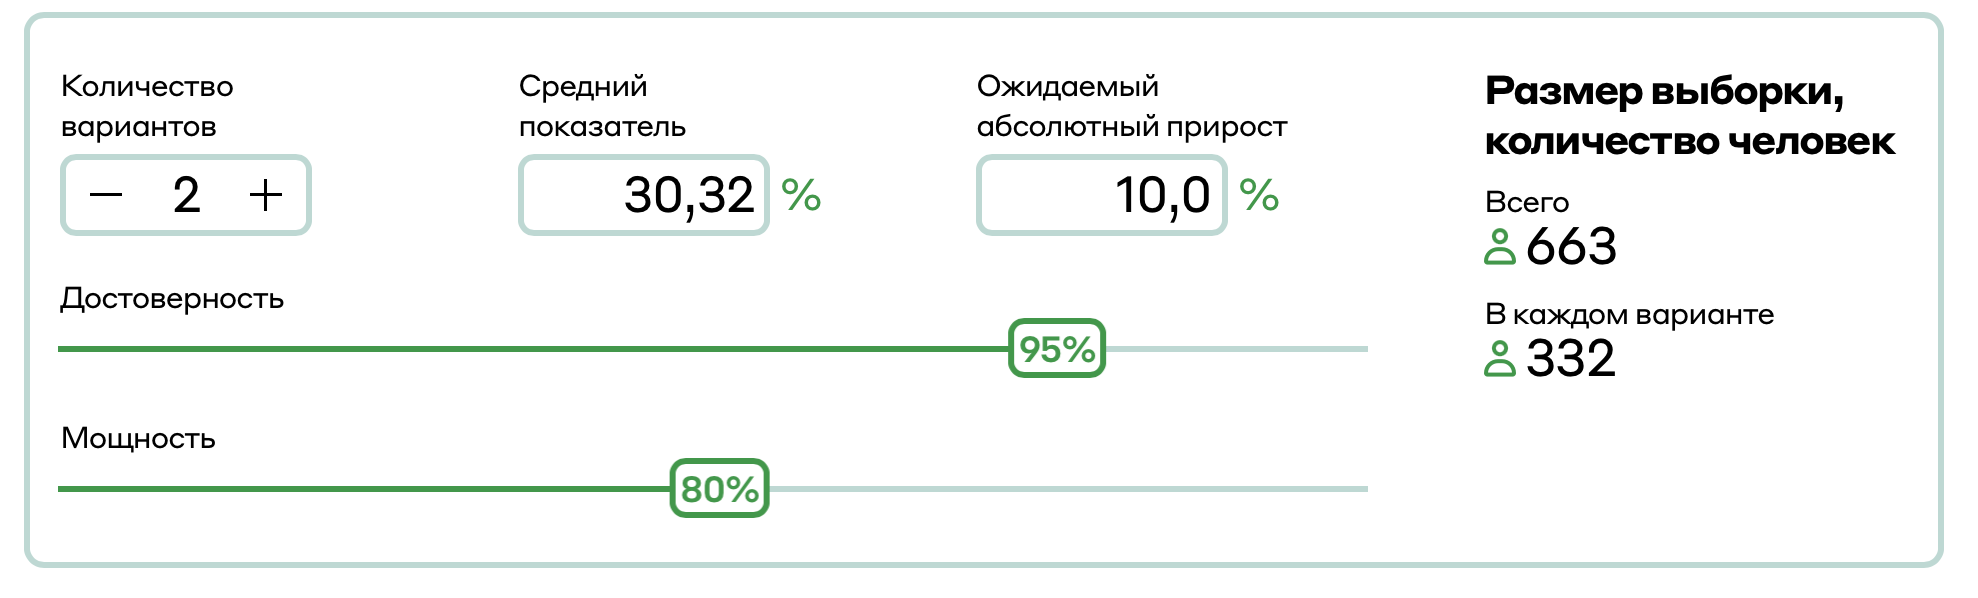

Как видно из результатов калькулятора, размер выборок у нас достаточный, значит, неравномерность распредеения не является критичной.

-Тест необходимо заканчивать в установленный в ТЗ срок, что поможет избежать проблеммы "прдглядывания", в нашем случае в тесте нет данных о событиях позднее 29 декабря, то есть тест был остановлен на 5 дней раньше.

- длительность теста должна быть не слишком долгая и не слишком короткая, чтобы  успеть достигнуть статистической значимости и делать вывод. Например, ещё не достигнута статистическая значимость, и результаты группы B колеблются, хотя и стабильно ниже результатов группы A. Смысла продолжать тест нет: лучше группы A группа B уже не станет, и прироста конверсии по переходам не будет.

Проверим оптимальность длительности нашего теста.
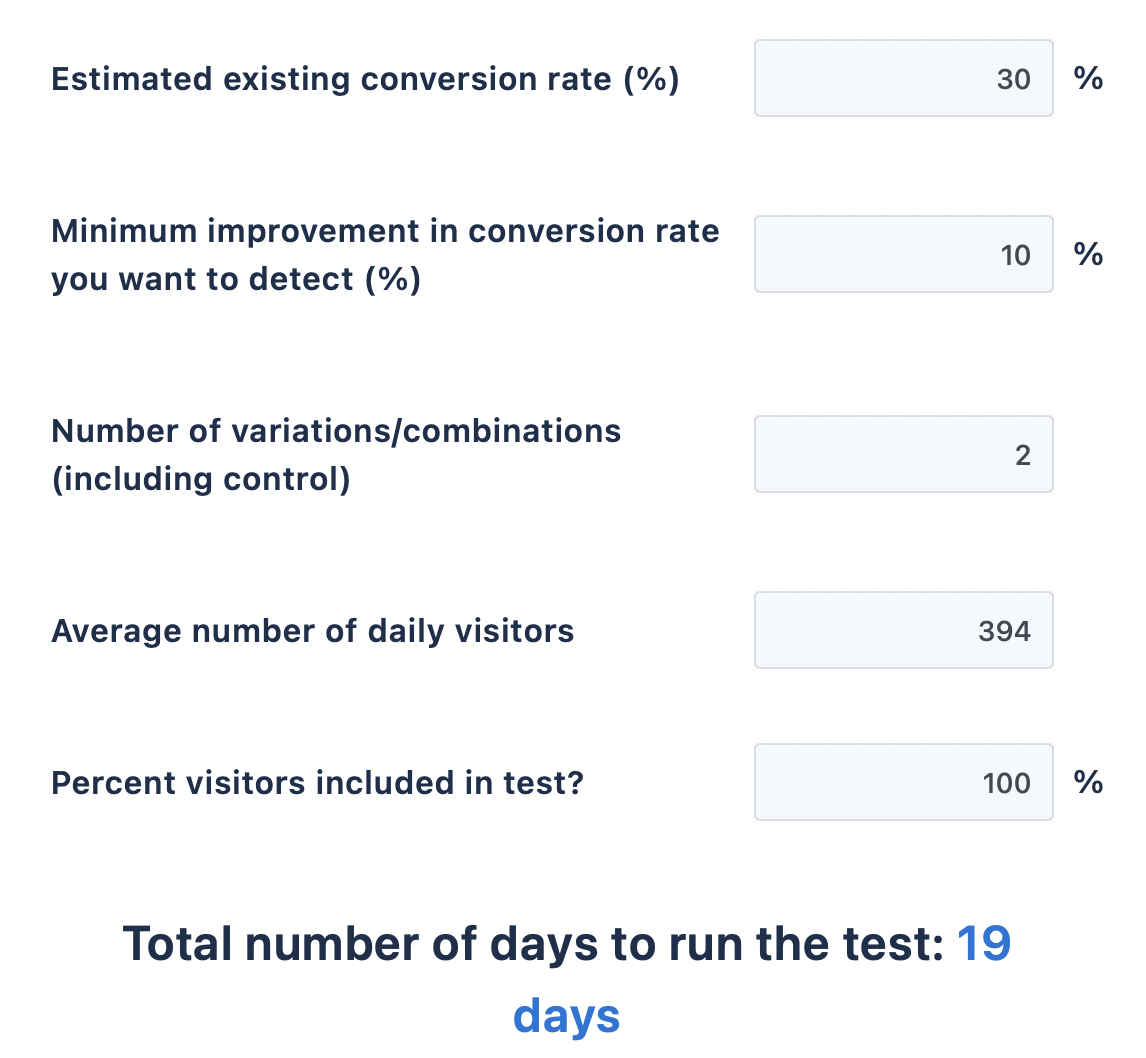

Как видно из результатов онлайн калькулятора длительность теста для подобных параметров должна составлять 19 дней, в нашем случае тест длился с 7 числа по 29, то есть 22 дня, что не противоречит условиям длительности теста.


- Период проведения не следует делать в разгар сезонной активности- праздники, например, в таком случае статистическая значимость  будет достигнута из-за аномальных колебаний, а не из-за изменений в продукте (интерфейсе).

<a id='20-bullet'></a>
## Оценка результатов A/B-тестирования. Проверка гипотез

Согласно ТЗ тест был коректно проведен в части доли % участникоы из Европы,
набор участников и окончание набора участников произведено согласно срокам ТЗ.
Однако есть ряд недостатков-нарушения срока окончания теста, проведение теста совпало с сезонными колебаниями активности покупателей.
Из анализа конверсий по воронке можно предполагать, что конверсия контрольной группы выше, чем конверсия экспериментальной группы и ожидаемое улучшение метрик не произошло.

Определим, есть ли статистически значимая разница между долями прошедших по воронке пользователей в группах А и В.

Гипотезы:
  -  Н0- статистически значимой разницы между долями прошедших по воронке пользователей в группах А и В нет
  - Н1- статистически значимая разница между долями прошедших по воронке пользователей в группах А и В есть

Критический уровень значимости alpha примем за 0,05.

Так как в анализе будет проводиться 3 множественных сравнения(3 теста согласно этапам воронки), то необходимо  скорректировать alpha, чтобы не совершить ошибки первого рода( вероятность отвергнуть нулевую гипотезу, потому что наблюдение отличается от предполагаемого значения слишком сильно и тест показал p-value меньше уровня значимости)


В нашем случае необходимо применить поправки Боннферони или Шидака, чтобы сохранить одно значимое различие в 5% случаев. 
**Поправка по методу Боннферони** -разделим уровень значимости на количество проверок гипотез - 0,05/3 = 0,0166

**Поправка по методу Шидака**
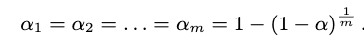

In [63]:
a = 1 - (1 - 0.05)**(1 / 3)
print(f" Уточненый а: {round(a,6)}")

 Уточненый а: 0.016952


Используя метод Шидака, критический уровень значимости а следовало бы уменьшить до 0,016952, так как тест Шидака считается более точным, применим более точный alpha.

Cогласно описанному выше алгоритму действий пользователей, нам нужно будет сопоставить доли уникальных пользователей, т.е. проверить три гипотезы о равенстве долей в группах А и В при конверсии в:

- просмотре карточек товаров (product_page)
- просмотре корзины (product_cart)
- покупке (purchase)

In [64]:
def z_test(df1, df2, event, alpha, n):
    '''    
Функция принимает на вход два датафрейма с логами и по заданному событию попарно проверяет 
есть ли статистически значимая разница между долями пользователей, совершивших его в группе 1 и группе 2.

Входные параметры:
    - df1, df2 - датафреймы с логами
    - event - событие
    - alpha - критический уровень статистической значимости
    - n - поправка Боннферони для критического уровня статистической значимости
    '''    
    
    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event_name'] == event]['user_id'].nunique(), 
                        df2[df2['event_name'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    print(success[0], success[1], n_users[0],n_users[1])
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [65]:
for event in ['product_page', 'product_cart', 'purchase']:
    z_test(new_part_events[new_part_events['group'] == 'A'], new_part_events[new_part_events['group'] == 'B'], event,.05, 3)
    print()

1476 429 2279 771
Событие: product_page
p-значение:  6.120730626113513e-06
Отвергаем нулевую гипотезу: между долями есть разница

686 214 2279 771
Событие: product_cart
p-значение:  0.21721122664962245
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

734 219 2279 771
Событие: purchase
p-значение:  0.048942596376941205
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



На этапе перехода к продуктовой странице есть статистическая разница между долями прошедших по воронке пользователей в группах А и В . Но по воронке видно, что это  различие в пользу группы А, которая работала с прошлой версией рекомендательной сиситемы(64,76% и 55,71%)

На этапах покупки и просмотра продуктовой корзины статистической разницы между долями прошедших по воронке пользователей в группах А и В  нет.

<a id='21-bullet'></a>
## Вывод

Согласно ТЗ тест был коректно проведен в части доли % участникоы из Европы,
набор участников и окончание набора участников произведено согласно срокам ТЗ.
Однако есть ряд недостатков-нарушения срока окончания теста, проведение теста совпало с сезонными колебаниями активности покупателей. В целом, по основным параметрам , указанным ТЗ, проведение  теста было корректным, поэтому можем доверять полученным результатам.

Общий вывод по итогам анализа А/В-теста внедрения новой рекомендательной системы: улучшений в метриках не произошло.На этапе перехода к продуктовой странице есть статистическая разница между долями прошедших по воронке пользователей в группах А и В . Но по воронке видно, что это различие в пользу группы А, которая работала с прошлой версией рекомендательной сиситемы(64,76% и 55,71%).

Рекомендации:

- необходимо проанализировать алгоритм новой системы рекомендации и внести изменения;

- перед проведением следующего А/В теста провести А/А тест, чтобы убедиться:
  - что инструмент «деления» трафика работает безошибочно . Так как распределение пресекающихся пользователей из нашего теста и паралльеьного теста совпадают , вызывает сомнение, что деление трафика происходит безошибочно(пользователи группа А , участвующие в обоих тестах распределены по группам А и Б нашего теста точно в таких же пропорциях, как распределены участники нашего теста). 
  - данные отправляются в системы аналитики корректно. У нас есть почти половина новых участников теста , для которых в данных по событиям нет информации, необходимо выснить, в чем причина этого отсутсвия данных.
- не проводить тесты в период сезонной активности пользователей
- соблюдать сроки начала и остановки тестов